# High throughput workflow example

iprPy handles calculation workflows in two stages:

1. Prepare creates multiple instances of a calculation both as input files and preliminary database entries.
2. Runner jobs then systematically run the calculations, update the database entries, and upload any generated calculation files into the database.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import atomman as am
import atomman.unitconvert as uc
import iprPy

import pandas as pd

## 1. Initial setup

To run the calculations, we need to define a database where the records are added and a run_directory where the calculations are performed.

In [2]:
# Set the "demo_1" run directory's path 
iprPy.settings.set_run_directory('demo_1', Path('.', 'run_directory/demo_1').absolute())

run_directory = iprPy.load_run_directory('demo_1')
print(run_directory)

if not Path(run_directory).exists():
    Path(run_directory).mkdir(parents=True)

C:\Users\lmh1\OneDrive - NIST\Documents\atomman-demo\run_directory\demo_1


In [3]:
# Define a local-style database
iprPy.settings.set_database('demo', style='local', host='demo_db')

database = iprPy.load_database('demo')
print(database)

Enter any other database parameters as key, value
Exit by leaving key blank
key: 

database style local at C:\Users\lmh1\OneDrive - NIST\Documents\atomman-demo\demo_db


The iprPy databases have a "potdb" attribute, which will build the atomman-style database from the first Notebook.

In [4]:
potdb = database.potdb
print(potdb.remote_database)
print(potdb.local_database)

database style cdcs at https://potentials.nist.gov/
database style local at C:\Users\lmh1\OneDrive - NIST\Documents\atomman-demo\demo_db


Download all EAM potentials for Au

In [5]:
potdb.download_lammps_potentials(
    pair_style = ['eam', 'eam/alloy', 'eam/fs'],
    symbols = 'Au',
    downloadfiles = True,
    verbose = True
)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 24.43it/s]


Found 19 matching potential_LAMMPS records in remote library
19 new records added to local
34 parameter files downloaded
Found 0 matching potential_LAMMPS_KIM records in remote library
0 new records added to local


Build the list of downloaded potentials

In [6]:
potential_LAMMPS_ids = database.get_records_df('potential_LAMMPS')['id'].tolist()
potential_LAMMPS_ids

['1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '1986--Foiles-S-M--Au--LAMMPS--ipr1',
 '1987--Ackland-G-J--Au--LAMMPS--ipr1',
 '1987--Ackland-G-J--Au--LAMMPS--ipr2',
 '1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '1989--Adams-J-B--Au--LAMMPS--ipr1',
 '1990--Ackland-G-J--Cu-Ag-Au--LAMMPS--ipr1',
 '2004--Zhou-X-W--Au--LAMMPS--ipr1',
 '2004--Zhou-X-W--Au--LAMMPS--ipr2',
 '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr1',
 '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2',
 '2004--Zhou-X-W--Cu-Ag-Au-Ni-Pd-Pt-Al-Pb-Fe-Mo-Ta-W-Mg-Co-Ti-Zr--LAMMPS--ipr1',
 '2005--Grochola-G--Au--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2',
 '2010--Olsson-P-A-T--Au--LAMMPS--ipr1',
 '2012--Norman-G-E--Au--LAMMPS--ipr1',
 '2017--OBrien-C-J--Pt-Au--LAMMPS--ipr1',
 '2017--Purja-Pun-G-P--Au--LAMMPS--ipr1']

Download all relaxed fcc crystals for the downloaded potentials

In [7]:
potdb.download_relaxed_crystals(
    method = 'dynamic',
    standing = 'good',
    family = 'A1--Cu--fcc',
    potential_LAMMPS_id = potential_LAMMPS_ids,
    symbols = 'Au',
    verbose = True
)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  4.39it/s]

Found 19 matching relaxed_crystal records in remote library
19 new records added to local


View the crystals and check lattice constant and cohesive energy values

- Crystals might not exist for some potentials depending on the potential and crystal structure
- Occasionally, there are multiple versions of a crystal for the same potential.  These correspond to alternate minima in the energy vs. volume equation of state.

In [8]:
crystals_df = database.get_records_df('relaxed_crystal')
print(crystals_df.keys())

Index(['name', 'key', 'url', 'method', 'standing', 'potential_LAMMPS_key',
       'potential_LAMMPS_id', 'potential_LAMMPS_url', 'potential_key',
       'potential_id', 'potential_url', 'family', 'family_url', 'parent_key',
       'parent_url', 'symbols', 'composition', 'crystalfamily', 'natypes', 'a',
       'b', 'c', 'alpha', 'beta', 'gamma', 'natoms', 'Epot (eV/atom)',
       'Ecoh (eV/atom)'],
      dtype='object')


In [9]:
crystals_df.sort_values(['potential_LAMMPS_id', 'a'])[['potential_LAMMPS_id', 'a', 'Ecoh (eV/atom)']]

,potential_LAMMPS_id,a,Ecoh (eV/atom)
11,1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1,4.080000,-3.930000
4,1986--Foiles-S-M--Au--LAMMPS--ipr1,4.080000,-3.930000
12,1987--Ackland-G-J--Au--LAMMPS--ipr1,4.078001,-3.789045
13,1987--Ackland-G-J--Au--LAMMPS--ipr2,4.078001,-3.789045
0,1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1,4.080000,-3.930000
15,1989--Adams-J-B--Au--LAMMPS--ipr1,4.080000,-3.930000
2,1990--Ackland-G-J--Cu-Ag-Au--LAMMPS--ipr1,4.078000,-3.789045
9,2004--Zhou-X-W--Au--LAMMPS--ipr1,4.079787,-3.930005
14,2004--Zhou-X-W--Au--LAMMPS--ipr2,4.080053,-3.930005
18,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr1,4.080063,-3.930005


## 2. Prepare relax_static calculations as a function of pressure

The prepare step is based on the input file variation of the individual calculation scripts.  In fact, prepare takes a similar input script with difference being that
- Keys can now have multiple values which can be specified by repeating the key with new values on new lines.
- The special buildcombos key can be used to call a pre-defined function that builds input values based on database entries.

In [12]:
calc = iprPy.load_calculation('relax_static')
print(calc.template)

# Input script for iprPy calculation relax_static

# Calculation Metadata
branch                          <branch>

# LAMMPS and MPI Commands
lammps_command                  <lammps_command>
mpi_command                     <mpi_command>

# Interatomic Potential
potential_file                  <potential_file>
potential_kim_id                <potential_kim_id>
potential_kim_potid             <potential_kim_potid>
potential_dir                   <potential_dir>

# Initial System Configuration
load_file                       <load_file>
load_style                      <load_style>
load_options                    <load_options>
family                          <family>
symbols                         <symbols>
box_parameters                  <box_parameters>

# System Manipulations
a_uvw                           <a_uvw>
b_uvw                           <b_uvw>
c_uvw                           <c_uvw>
atomshift                       <atomshift>
sizemults                       <sizemults>

# L

When prepare is called, you can pass in either the text key-value script or corresponding kwargs.  Here, we'll do the latter for simplicity.

In [13]:
prepare_terms = {}

prepare_terms['lammps_command'] = 'lmp'


# Use the atomicparent buildcombos function to generate potential and system info from the database
prepare_terms['buildcombos'] = 'atomicparent load_file parent'  # first term is type, second is an included key, third is name to assign to combo

# Modify combo using "parent_" keys
prepare_terms['parent_record'] = 'relaxed_crystal'
prepare_terms['parent_standing'] = 'good'
prepare_terms['parent_method'] = 'dynamic'

# Prepare limiters
prepare_terms['parent_potential_id'] = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2'  # use only this potential
prepare_terms['parent_family'] = 'A1--Cu--fcc'
prepare_terms['parent_composition'] = 'Au'

# List pressures to evaluate
pressures = [
    '0 GPa',
    '10 GPa',
    '20 GPa',
    '30 GPa',
    '40 GPa',
    '50 GPa',
    '60 GPa',
    '70 GPa',
    '80 GPa',
    '90 GPa',
    '100 GPa'    
]
prepare_terms['pressure_xx'] = prepare_terms['pressure_yy'] = prepare_terms['pressure_zz'] = pressures



Now we prepare!

In [15]:
database.prepare(run_directory, calc, **prepare_terms)

11 existing calculation records found
1 matching interatomic potentials found
1 matching atomic parents found


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.35it/s]

11 calculation combinations to check
0 new records to prepare



preparing: 0it [00:00, ?it/s]


[]

# 3. Run

You can start runners either from within Python using Database.runner()

If you've saved the database and run_directory info, you can start runners from the command line with
    
    iprPy runner {database_name} {run_directory_name}
    
Multiple runners can operate simultaneously without conflict, and can be assigned any number of cores to work with.

In [16]:
database.runner(run_directory)

Runner started with pid 12512
402494a6-975a-4363-b9ec-852cf3b24061
sim calculated successfully

8810d6be-a16b-4790-aabb-dd2b30ffd6a3
sim calculated successfully

1c83ac48-fd13-4ae2-934f-44c427be67dd
sim calculated successfully

fb44adea-2073-4b43-a345-3433a56832c8
sim calculated successfully

a4ed53ab-fc8d-4ed8-ba5b-a1f3a23a8486
sim calculated successfully

c6a459fe-433e-47fd-b9e3-a6c1e4132bd1
sim calculated successfully

fdbf44e6-5e8d-4f08-8c3a-1cd5c20a4513
sim calculated successfully

2f50d466-3bd1-4ec5-ad63-3f8eefa605a1
sim calculated successfully

cd6d416a-6496-4bd9-92d3-ed8d46a7291a
sim calculated successfully

5171770d-fafa-4dac-8056-a1532073e6a5
sim calculated successfully

9f52fee9-cf7d-41c5-b6fd-8215ec032c10
sim calculated successfully

No simulations left to run


# 4. Analyze

In [23]:
relaxes, relaxes_df = database.get_records('calculation_relax_static',
                                           potential_LAMMPS_id = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2',
                                           status = 'finished',
                                           return_df = True,
                                           refresh_cache=True,
                                       )

In [24]:
relaxes_df.keys()

Index(['name', 'key', 'url', 'iprPy_version', 'atomman_version', 'script',
       'branch', 'status', 'lammps_version', 'potential_LAMMPS_key',
       'potential_LAMMPS_id', 'potential_LAMMPS_url', 'potential_key',
       'potential_id', 'potential_url', 'load_file', 'load_style',
       'load_options', 'parent_key', 'family', 'family_url', 'symbols',
       'composition', 'a_mult1', 'a_mult2', 'b_mult1', 'b_mult2', 'c_mult1',
       'c_mult2', 'atomshift', 'a_uvw', 'b_uvw', 'c_uvw', 'energytolerance',
       'forcetolerance', 'maxiterations', 'maxevaluations', 'maxatommotion',
       'temperature', 'pressure_xx', 'pressure_yy', 'pressure_zz',
       'pressure_xy', 'pressure_xz', 'pressure_yz', 'lx', 'ly', 'lz', 'xy',
       'xz', 'yz', 'E_pot', 'measured_temperature', 'measured_pressure_xx',
       'measured_pressure_yy', 'measured_pressure_zz', 'measured_pressure_xy',
       'measured_pressure_xz', 'measured_pressure_yz'],
      dtype='object')

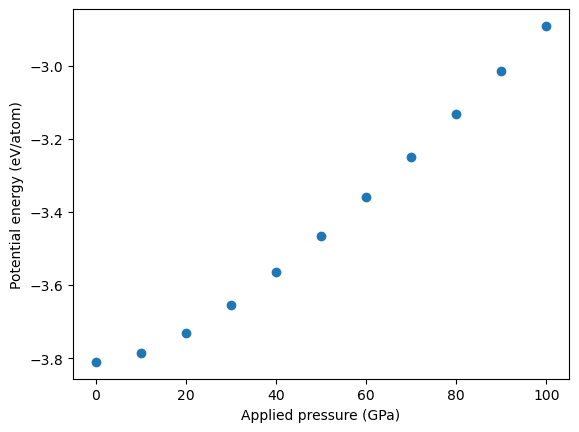

In [25]:
plt.plot(uc.get_in_units(relaxes_df.pressure_xx, 'GPa'), 
         uc.get_in_units(relaxes_df.E_pot, 'eV'), 'o')
plt.xlabel('Applied pressure (GPa)')
plt.ylabel('Potential energy (eV/atom)')
plt.show()

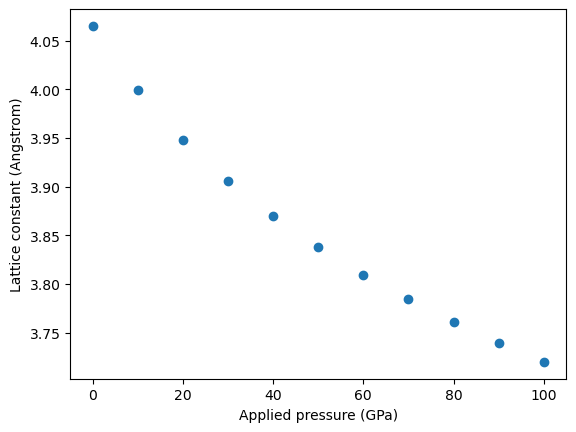

In [26]:
plt.plot(uc.get_in_units(relaxes_df.pressure_xx, 'GPa'), 
         uc.get_in_units(relaxes_df.lx, 'eV'), 'o')

plt.xlabel('Applied pressure (GPa)')
plt.ylabel('Lattice constant (Angstrom)')
plt.show()

## 5. Now, do elastic constants...

In [27]:
calc = iprPy.load_calculation('elastic_constants_static')

In [28]:
prepare_terms = {}

prepare_terms['lammps_command'] = 'lmp'


# Use the atomicarchive buildcombos function to pull final configurations from relax_static results
prepare_terms['buildcombos'] = 'atomicarchive load_file parent'  # first term is type, second is an included key, third is name to assign to combo

# Modify combo using "parent_" keys
prepare_terms['parent_record'] = 'calculation_relax_static'
prepare_terms['parent_load_key'] = 'final-system'
prepare_terms['parent_status'] = 'finished'

# Prepare limiters
prepare_terms['parent_potential_id'] = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2'  # use only this potential
prepare_terms['parent_family'] = 'A1--Cu--fcc'
prepare_terms['parent_composition'] = 'Au'

In [30]:
database.prepare(run_directory, calc, **prepare_terms)

11 existing calculation records found
1 matching interatomic potentials found
11 matching atomic archives found


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.41it/s]

11 calculation combinations to check
0 new records to prepare



preparing: 0it [00:00, ?it/s]


[]

In [31]:
database.runner(run_directory)

Runner started with pid 12512
bb690f7f-b1a5-4a0d-b640-4f9fc2e7748a
sim calculated successfully

99f85b7a-470e-40b4-91bc-b4ad115b66e2
sim calculated successfully

d10ec326-6721-4d43-8286-a63b8eb66f02
sim calculated successfully

23e17970-2043-4905-8180-420167c52837
sim calculated successfully

364cdb03-8a6e-43e5-9a40-b72f2ee1952a
sim calculated successfully

ffe238ff-1fdf-4a34-860c-90224976b037
sim calculated successfully

1e5ad968-51fa-4582-ab54-8e1f2af8d2e6
sim calculated successfully

9094bfc8-f9ba-4556-9b45-c945a620d5c7
sim calculated successfully

b5e5f0f8-b76d-45ad-a298-97445159e606
sim calculated successfully

76171987-a1ea-4bd2-9782-9407e945bb05
sim calculated successfully

ec802e9a-ff90-4810-8e19-47dd7b6a3f97
sim calculated successfully

No simulations left to run


In [32]:
cijs, cijs_df = database.get_records('calculation_elastic_constants_static',
                                     potential_LAMMPS_id = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2',
                                     status = 'finished',
                                     return_df = True,
                                     refresh_cache = True)

In [33]:
cijs_df.keys()

Index(['name', 'key', 'url', 'iprPy_version', 'atomman_version', 'script',
       'branch', 'status', 'lammps_version', 'potential_LAMMPS_key',
       'potential_LAMMPS_id', 'potential_LAMMPS_url', 'potential_key',
       'potential_id', 'potential_url', 'load_file', 'load_style',
       'load_options', 'parent_key', 'family', 'family_url', 'symbols',
       'composition', 'a_mult1', 'a_mult2', 'b_mult1', 'b_mult2', 'c_mult1',
       'c_mult2', 'atomshift', 'a_uvw', 'b_uvw', 'c_uvw', 'energytolerance',
       'forcetolerance', 'maxiterations', 'maxevaluations', 'maxatommotion',
       'strainrange', 'C', 'raw_Cij_negative', 'raw_Cij_positive'],
      dtype='object')

In [34]:
def extract_C11_GPa(series):
    return(uc.get_in_units(series.C.Cij[0,0], 'GPa'))
def extract_C12_GPa(series):
    return(uc.get_in_units(series.C.Cij[0,1], 'GPa'))
def extract_C44_GPa(series):
    return(uc.get_in_units(series.C.Cij[3,3], 'GPa'))

cijs_df['C11'] = cijs_df.apply(extract_C11_GPa, axis=1)
cijs_df['C12'] = cijs_df.apply(extract_C12_GPa, axis=1)
cijs_df['C44'] = cijs_df.apply(extract_C44_GPa, axis=1)

Now, we have a slight issue as the elastic constant calculations do not contain pressure information.  However, they do have a 'parent_key' which corresponds to the relax_static record that it was based on.

In [35]:
merged_df = pd.merge(relaxes_df, cijs_df, left_on='key', right_on='parent_key')

In [36]:
merged_df.keys()

Index(['name_x', 'key_x', 'url_x', 'iprPy_version_x', 'atomman_version_x',
       'script_x', 'branch_x', 'status_x', 'lammps_version_x',
       'potential_LAMMPS_key_x',
       ...
       'maxiterations_y', 'maxevaluations_y', 'maxatommotion_y', 'strainrange',
       'C', 'raw_Cij_negative', 'raw_Cij_positive', 'C11', 'C12', 'C44'],
      dtype='object', length=104)

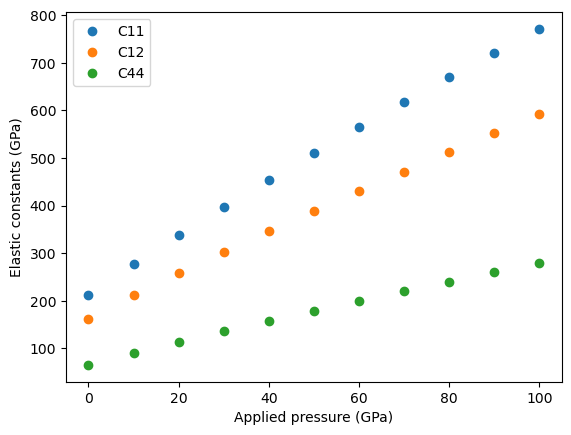

In [37]:
plt.plot(uc.get_in_units(merged_df.pressure_xx, 'GPa'), merged_df.C11, 'o', label='C11') 
plt.plot(uc.get_in_units(merged_df.pressure_xx, 'GPa'), merged_df.C12, 'o', label='C12')
plt.plot(uc.get_in_units(merged_df.pressure_xx, 'GPa'), merged_df.C44, 'o', label='C44')

plt.xlabel('Applied pressure (GPa)')
plt.ylabel('Elastic constants (GPa)')
plt.legend()
plt.show()

**Cleanup**

In [38]:
import shutil
import os

print('Do you really want to clean everything up?')
clean = input('yes or no?')

if clean == 'yes':
    os.chdir('..')
    shutil.rmtree(database.host)
    shutil.rmtree(run_directory)
    iprPy.settings.unset_database('demo')
    iprPy.settings.unset_run_directory('demo_1')

Do you really want to clean everything up?


yes or no? yes


Database demo found
Delete settings? (must type yes): 

 yes


Run directory demo_1 found
Delete settings? (must type yes): 

 yes


In [33]:
database.host

WindowsPath('C:/Users/lmh1/OneDrive - NIST/Documents/atomman-demo/testing_db')